# Machine Learning Engineer Nanodegree
## Capstone
## Project: Quora Question Pairs
Determine if a pair of questions submitted to Quora are duplicates with the same intent.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd

### Data Exploration

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
num_questions = len(train_data)
print "Question Pairs: ", num_questions
question_ids = pd.Series(train_data['qid1'].tolist() + train_data['qid2'].tolist())
print "Unique Questions: %d" %len(np.unique(question_ids))
groupby_duplicates = train_data.groupby("is_duplicate")['id'].count()
known_duplicates = groupby_duplicates[1]
print "Known Duplicates: ", known_duplicates
ratio_duplicates = round((known_duplicates / float(num_questions)) * 100, 2)
print  "Ratio of Duplicate Pairs: ", ratio_duplicates, "%"

Question Pairs:  404290
Unique Questions: 537933
Known Duplicates:  149263
Ratio of Duplicate Pairs:  36.92 %


In [5]:
test_data = pd.read_csv("test.csv")
test_data.head(5)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [6]:
test_question_pairs = len(test_data)
print "Question Pairs: ", test_question_pairs

Question Pairs:  2345796


### Exploratory Visualization
#### Word Cloud
I will begin by generating a word cloud to get an idea of the topics our questions will be about. The larger words will give us an idea of overall themes or patterns we might see across the dataset.

In [9]:
# import libs for visualization
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords=set(STOPWORDS)

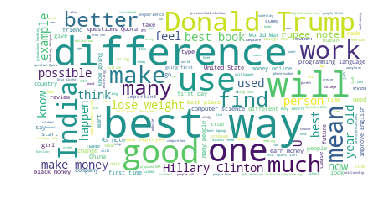

In [13]:
# Combine all questions for creating single wordcloud
train_all_questions = pd.Series(" ".join(train_data['question1'].astype(str)) + " ".join(train_data['question2'].astype(str)))

# Generate a word cloud image
train_wordcloud = WordCloud(
                            background_color='white',
                            stopwords=stopwords,
                            max_font_size=50
                           ).generate(" ".join(train_all_questions))

# Display the generated image
fig = plt.figure(1)
plt.imshow(train_wordcloud)
plt.axis("off")
plt.show()

# Save the image for the report
fig.savefig("wordcloud.png", dpi=900)

#### TF-IDF Vectors
Next we will generate a Tf-idf-weighted term-document matrix. 
Tf-idf is term frequency-inverse document frequency, which is a statistic that reflects the importance of a word in a specific document (in our case, a question) relative to all of the words in a collection of documents known as the corpus (in our case, all of the questions).

In [16]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
# import tools for Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

# Learn the vocabulary dictionary and return term-document matrix. 
tfidf_result = vectorizer.fit_transform(train_all_questions)

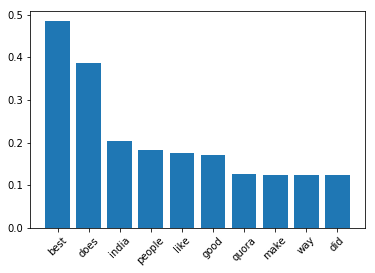

In [51]:
# https://stackoverflow.com/a/16078639
scores = zip(vectorizer.get_feature_names(),
            np.asarray(tfidf_result.sum(axis=0)).ravel())

sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

labels, ys = zip(*sorted_scores[:10])
xs = np.arange(len(labels))
width = .8

plt.bar(xs, ys, width)
plt.xticks(xs, labels, rotation="45")

plt.savefig('top10words.png')